In [1]:
import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as pyplot
from matplotlib import cm
import plotly.express as px
import botorch
from botorch.models.gpytorch import GPyTorchModel

import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2
print(gpytorch.__version__)

1.3.1


In [2]:
# load data
fe_data = pd.read_csv('C:\\Users\\roberttk\\Desktop\\SLAC_RA\\DATA\\ferroelectric_data\\FE_HZCO_samples_210219.csv', index_col=0)
fe_data['log(RTA time)'] = np.log(fe_data['RTA time (sec)'])
fe_data

,Thickness (nm),RTA temperature (C),RTA time (sec),CeO2 doping,"2Pr (uC/cm2), Pristine state",log(RTA time)
1,10,350.0,30.0,4.4,0.31095,3.401197
2,10,350.0,60.0,4.4,3.05088,4.094345
3,10,350.0,120.0,4.4,11.48724,4.787492
4,10,350.0,300.0,4.4,27.85326,5.703782
5,10,350.0,600.0,4.4,NaN,6.396930
6,10,360.0,30.0,4.4,5.91482,3.401197
7,10,380.0,30.0,4.4,20.16876,3.401197
8,10,400.0,30.0,4.4,26.66847,3.401197
9,10,400.0,300.0,4.4,35.18615,5.703782
10,10,500.0,30.0,4.4,30.25570,3.401197


In [3]:
# plot?...
fig = px.scatter_3d(fe_data, x='RTA temperature (C)', y='RTA time (sec)', 
                        z='2Pr (uC/cm2), Pristine state')
fig.update_layout(scene=dict(
                            # xaxis=dict(nticks=4, range=[200, 800])
                            # yaxis=dict(range=[0, 500])
                            ),
                   margin=dict(r=20, l=10, b=10, t=10)
                   )
fig.show()

In [4]:
# prep training data
from sklearn.preprocessing import StandardScaler
T_scaler = StandardScaler()

# filter training data 
mask = ~np.isnan(fe_data['2Pr (uC/cm2), Pristine state'])
train_x = torch.Tensor([fe_data['RTA temperature (C)'][mask].values, 
                    #    np.log(fe_data['RTA time (sec)'][mask].values)*10]).T
                       fe_data['RTA time (sec)'][mask].values]).T
# train_x = torch.Tensor(T_scaler.fit_transform(train_x))
train_raw_y = torch.Tensor(fe_data['2Pr (uC/cm2), Pristine state'][mask].values)
train_y = train_raw_y #(train_raw_y - train_raw_y.mean()) / (train_raw_y.max() - train_raw_y.min())

# define grid between bounds of RTA time, RTA temp
grid_bounds = [(train_x[:,0].min(), train_x[:,0].max() ), 
                (train_x[:,1].min(), train_x[:,1].max() ) ]
grid_size = 20
grid = torch.zeros(grid_size, len(grid_bounds))

for i in range(len(grid_bounds)):
    grid_diff = float(grid_bounds[i][1] - grid_bounds[i][0]) / (grid_size - 2)
    grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, 
                                grid_bounds[i][1] + grid_diff, grid_size)
                        
# Set up grid for predictions

n=30 # number of points in grid, different from one supplied to GP
test_grid = torch.zeros(n, len(grid_bounds))
for i in range(len(grid_bounds)): # Creates a grid s.t. grid[:, i] is the vector along dimension i
    grid_diff = float(grid_bounds[i][1] - grid_bounds[i][0]) / (n - 2)
    print(grid_diff)
    test_grid[:, i] = torch.linspace(grid_bounds[i][0] - grid_diff, 
                                grid_bounds[i][1] + grid_diff, n)

test_x = torch.zeros(int(pow(n, 2)), 2)
for i in range(n): #Basically making grid 
    for j in range(n):
        test_x[i*n + j][0] = test_grid[i, 0]
        test_x[i*n + j][1] = test_grid[j, 1]


12.5
9.985714503696986


In [5]:
def intermediate_plot(f, ax, obs, title):
    im = ax.imshow(obs.mean.view(n, n), aspect='equal',
                extent=[grid_bounds[0][0].item(), grid_bounds[0][1].item(),
                            grid_bounds[1][0].item(), grid_bounds[1][1].item()])
    f.colorbar(im)
    # ax.scatter(train_x[:,0], train_x[:,1], c=train_y)
    ax.set_title(title)

In [6]:
# initialize GP model
class GridGP(gpytorch.models.ExactGP, GPyTorchModel):

    _num_outputs = 1
    def __init__(self, train_x, train_y, likelihood):
        super(GridGP, self).__init__(train_x, train_y, likelihood)  
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
                                gpytorch.kernels.RBFKernel(ard_num_dims=2) )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GridGP(train_x, train_y, likelihood)


model.covar_module.base_kernel.lengthscale = torch.Tensor([100, 100])


Iter 1/1000 - Loss: 115.539  lengthscale1: [[100. 100.]]   noise: [0.6932472]
Iter 101/1000 - Loss: 3.712  lengthscale1: [[147.8237  167.22028]]   noise: [60.83506]
Iter 201/1000 - Loss: 3.649  lengthscale1: [[ 96.49589 159.42926]]   noise: [60.13623]
Iter 301/1000 - Loss: 3.588  lengthscale1: [[ 38.546326 153.28024 ]]   noise: [58.547546]
Iter 401/1000 - Loss: 3.574  lengthscale1: [[ 31.423906 148.31145 ]]   noise: [55.88617]
Iter 501/1000 - Loss: 3.562  lengthscale1: [[ 31.27105 144.43384]]   noise: [52.646633]
Iter 601/1000 - Loss: 3.547  lengthscale1: [[ 31.117594 141.95442 ]]   noise: [48.79314]
Iter 701/1000 - Loss: 3.528  lengthscale1: [[ 30.989494 140.72655 ]]   noise: [44.22793]
Iter 801/1000 - Loss: 3.504  lengthscale1: [[ 30.880552 140.4472  ]]   noise: [38.78753]
Iter 901/1000 - Loss: 3.471  lengthscale1: [[ 30.77545 140.81674]]   noise: [32.184093]


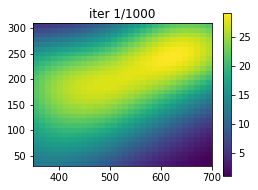

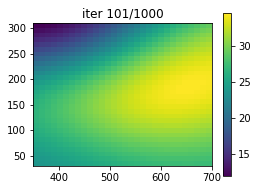

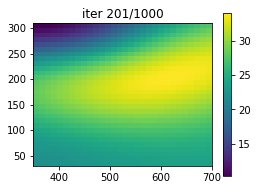

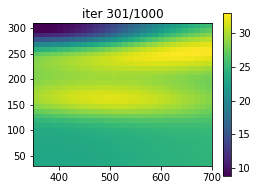

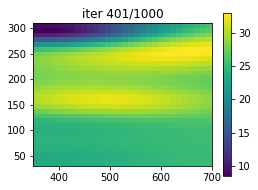

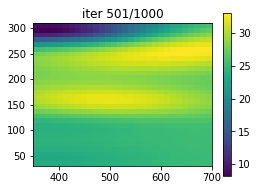

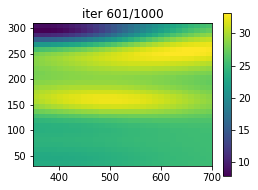

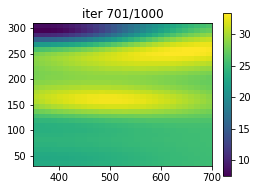

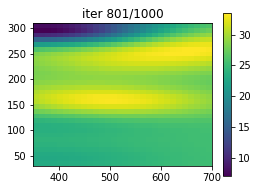

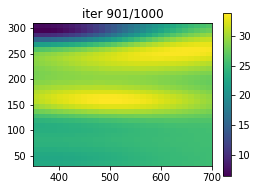

In [7]:
# Training loop
training_iter = 1000

# Place in training mode
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=10)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()

    output = model(train_x)

    loss = -mll(output, train_y)
    loss.backward()

    if i % 100 == 0: 
        print('Iter %d/%d - Loss: %.3f  lengthscale1: %s   noise: %s' % (
        i+1, training_iter, loss.item(), 
        model.covar_module.base_kernel.lengthscale.detach().numpy(),
        model.likelihood.noise.detach().numpy()
        )) 

        # get a quick snapshot of intermediate 
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            obs = likelihood(model(test_x))

            f, ax = plt.subplots(1, 1, figsize=(4,3))
            intermediate_plot(f, ax, obs, f'iter {i+1}/{training_iter}')
        model.train()
        likelihood.train()


    optimizer.step()

In [8]:
# make predictions
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    obs = likelihood(model(test_x))
# print(f'train data: {fe_data["2Pr (uC/cm2), Pristine state"][1]}')
# print(f'observed: {obs.mean}')

In [9]:
# non-log scale

pred_labels = obs.mean.view(n, n)
# plot?...
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=pred_labels.numpy().T, x=test_grid[:,0], y=test_grid[:,1], name='GP regression')])
fig.add_trace(go.Scatter3d(x=train_x[:,0].numpy(),y=train_x[:,1].numpy(),  
                        z=train_y.numpy(), mode='markers', marker={'color':'darkgreen'}, name='trianing data'))
fig.update_layout( #width=1000, height=800,
                  legend=dict(orientation="h", yanchor="top", y=1.02, xanchor="left",x=1),
                   margin=dict(r=20, l=10, b=10, t=10), 
                    scene=dict(
                    xaxis_title="RTA temperature (C)",
                    yaxis_title="RTA time (sec)",
                    zaxis_title='2Pr (uC/cm2), Pristine')
                )
fig.show()

In [13]:
# # log scale
# pred_labels = obs.mean.view(n, n)
# # plot?...
# import plotly.graph_objects as go
# fig = go.Figure(data=[go.Surface(z=pred_labels.numpy().T, x=test_grid[:,0], y=test_grid[:,1], name='GP regression')])
# fig.add_trace(go.Scatter3d(x=train_x[:,0].numpy(),y=train_x[:,1].numpy(),  
#                         z=train_y.numpy(), mode='markers', marker={'color':'darkgreen'}, name='trianing data'))
# fig.update_layout( #width=1000, height=800,
#                   legend=dict(orientation="h", yanchor="top", y=1.02, xanchor="left",x=1),
#                    margin=dict(r=20, l=10, b=10, t=10), 
#                     scene=dict(
#                     xaxis_title="RTA temperature (C)",
#                     yaxis_title="RTA time (sec)",
#                     zaxis_title='2Pr (uC/cm2), Pristine')
#                 )
# fig.show()

In [14]:
from mltools.acq_funcs import EI, PI, cust_acq, thompson
bounds = [1,1]

PI_acq = PI(obs, bounds, train_y)
PI_acq_shape = PI_acq.detach().numpy().reshape(30,30).T

EI_acq = EI(obs, bounds, train_y)
EI_acq_shape = EI_acq.detach().numpy().reshape(30,30).T

ca_acq = cust_acq(obs, bounds, train_y)
ca_acq_shape = ca_acq.detach().numpy().reshape(30,30).T

th_acq = thompson(obs, bounds, train_y)
th_acq_shape = th_acq.detach().numpy().reshape(30,30).T
# fig = go.Figure(data=[go.Surface(z=acq, x=test_grid[:,0], y=test_grid[:,1])])


In [15]:
ei = np.unravel_index(EI_acq_shape.argmax(), EI_acq_shape.shape)
pi = np.unravel_index(PI_acq_shape.argmax(), PI_acq_shape.shape)
ca = np.unravel_index(ca_acq_shape.argmax(), ca_acq_shape.shape)
th = np.unravel_index(th_acq_shape.argmax(), th_acq_shape.shape)

In [16]:
pred_var = obs.variance.view(n, n).detach().numpy().T
lower, upper = obs.confidence_region()
upper_surf = upper.detach().numpy().reshape(30,30).T
lower_surf = lower.detach().numpy().reshape(30,30).T

ucb = np.unravel_index(upper_surf.argmax(), upper_surf.shape)
max_var = np.unravel_index(pred_var.argmax(), pred_var.shape)
ei = np.unravel_index(EI_acq_shape.argmax(), EI_acq_shape.shape)
pi = np.unravel_index(PI_acq_shape.argmax(), PI_acq_shape.shape)

# plot?...
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z = upper_surf, x=test_grid[:,0], y=test_grid[:,1], opacity=0.5, showscale=False)])
fig.add_trace(go.Surface(z = lower_surf, x=test_grid[:,0], y=test_grid[:,1], opacity=0.5, showscale=False))
fig.add_trace(go.Scatter3d(x=train_x[:,0].numpy(), y=train_x[:,1].numpy(), 
                            z=train_y.numpy(), mode='markers', name='training data', marker={'color':'darkgreen'}))

fig.add_trace(go.Scatter3d(x=test_grid[ucb[1], 0].numpy(), y=test_grid[ucb[0], 1].numpy(), 
                            z=[pred_labels[ucb[0], ucb[1]]], mode='markers', name='max(upper confidence bound)')) 
fig.add_trace(go.Scatter3d(x=test_grid[th[1], 0].numpy(), y=test_grid[th[0],1].numpy(), 
                            z=[pred_labels[th[0], th[1]].detach().numpy()], mode='markers', name='max(thompson)')) 
fig.add_trace(go.Scatter3d(x=test_grid[pi[1], 0].numpy(), y=test_grid[pi[0], 1].numpy(), z=[pred_labels[pi[0], pi[1]]], mode='markers', name='max(pi)'))

fig.add_trace(go.Scatter3d(x=test_grid[ei[1], 0].numpy(), y=test_grid[ei[0], 1].numpy(), z=[pred_labels[ei[0], ei[1]]], mode='markers', name='max(ei)'))

# fig.add_trace(go.Scatter3d(x=test_grid[ca[1], 0].numpy(), y=test_grid[ca[0], 1].numpy(), z=[pred_labels[ca[0], ca[1]]], mode='markers', name='max(ca)'))


fig.update_layout( width=1000, height=600,
                  margin=dict(r=20, l=10, b=10, t=10),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right",x=1),
                  scene=dict(
                    xaxis_title="RTA temperature (C)",
                    yaxis_title="RTA time (sec)",
                    zaxis_title='2Pr (uC/cm2), Pristine')
                  )
fig.show()

In [23]:
print(test_grid[ei[1], 0], test_grid[ei[0], 1])
print(test_grid[pi[1], 0], test_grid[pi[0], 1])
print(test_grid[ca[1], 0], test_grid[ca[0], 1])
print(test_grid[ucb[1], 0], test_grid[ucb[0], 1])
print(test_grid[th[1], 0], test_grid[th[0], 1])


tensor(440.9483) tensor(199.9138)
tensor(402.1552) tensor(279.7168)
tensor(440.9483) tensor(199.9138)
tensor(389.2241) tensor(309.6429)
tensor(544.3965) tensor(150.0370)


In [24]:
print(pred_labels[ei[0], ei[1]])
print(pred_labels[pi[0], pi[1]])
print(pred_labels[ca[0], ca[1]])
print(pred_labels[ucb[0], ucb[1]])
print(pred_labels[th[0], th[1]])


tensor(22.8594)
tensor(22.4989)
tensor(22.8594)
tensor(22.2030)
tensor(24.7868)


In [58]:
fig = go.Figure(data=[go.Surface(z=PI_acq_shape, x=test_grid[:,0], y=test_grid[:,1])])
fig.add_trace(go.Scatter3d(x=test_grid[pi[1], 0].numpy(), y=test_grid[pi[0], 1].numpy(), z=[PI_acq_shape[pi[0], pi[1]]], mode='markers', name='max(pi)'))
fig.show()

In [59]:
fig = go.Figure(data=[go.Surface(z=EI_acq_shape, x=test_grid[:,0], y=test_grid[:,1])])
fig.add_trace(go.Scatter3d(x=test_grid[ei[1], 0].numpy(), y=test_grid[ei[0], 1].numpy(), z=[EI_acq_shape[ei[0], ei[1]]], mode='markers', name='max(pi)'))
fig.show()

In [16]:
Zn = Z.detach().numpy()
temp = scipy.stats.norm.cdf(Zn)

tensor([[350.,  30.],
        [350.,  60.],
        [350., 120.],
        [350., 300.],
        [360.,  30.],
        [380.,  30.],
        [400.,  30.],
        [400., 300.],
        [500.,  30.],
        [600.,  30.],
        [700.,  30.]])